Final Project 
======

Kaggle Competition 
-----

For this project I chose to do the active competition [San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime/). I'll test out a number of different algorithms with test data, but this seems like probably RandomForest a Neural Network 2 levels deep will have the best results. I am interested in this type of analysis as it is data science that contributes to the common good.

#### Import libraries

In [225]:
# Pandas and numpy
import pandas as pd
import numpy as np

# sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest,\
                        SelectPercentile, f_classif
from sklearn.decomposition import PCA

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# GIS functionality
from mpl_toolkits.basemap import Basemap, cm
import cartopy.io.shapereader as shpreader
import fiona
import pysal 
from pyproj import Proj
from pysal.cg.shapes import Point
from pysal.cg.locators import PolygonLocator, PointLocator, BruteForcePointLocator 
from pysal.cg.sphere import arcdist

#### Part 1 - Submit first (bad) try

In [182]:
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


In [183]:
train_raw.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [184]:
test_raw.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [185]:
sample_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [186]:
train_data\
,train_labels = train_raw[['DayOfWeek'\
                                     ,'PdDistrict'\
                                     ,'Address'\
                                     ,'X'\
                                     ,'Y']][2001:]\
                            ,train_raw['Category'][2001:]
dev_data\
,dev_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][:1000]\
                            ,train_raw['Category'][:1000]
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
test_data = test_raw[['DayOfWeek'\
                     ,'PdDistrict'\
                     ,'Address'\
                     ,'X'\
                     ,'Y']]

In [187]:
rf = RandomForestClassifier() #leaving with default settings for now

Data needs to be preprocessed for RF in sklearn

In [188]:
def recode(df):
    numerics = ['float16', 'float32', 'float64']
    ints = ['int16', 'int32', 'int64']
    for i in range(df.shape[1]):
        t = df.iloc[:,i].dtype
        if t not in numerics or ints:
            le = LabelEncoder()
            le.fit(df.iloc[:,i])
            df.iloc[:,i] = le.transform(df.iloc[:,i])
        elif t not in ints:
            df.iloc[:,i] = scale(df.iloc[:,i])
    return df

def recode_labels(df):
    le = LabelEncoder()
    le.fit(df)
    return le

class MultiColumnLabelEncoder:
    ''' Create a class that encodes
        labels for a matrix of data
    '''
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here
    
    def get_params(self, deep=True):
        out = dict()
        if self.columns: out['columns'] = columns
        return out

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        numerics = ['float16', 'float32', 'float64']
        ints = ['int16', 'int32', 'int64']
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                if col.dtype in numerics or ints:
                    output[col] = LabelEncoder().fit_transform(output[col])
                elif col.dtype not in ints:
                    output[col] = scale(output[col])
        else:
            for colname,col in output.iteritems():
                if col.dtype in numerics or ints:
                    output[colname] = LabelEncoder().fit_transform(output[colname])
                elif col.dtype not in ints:
                    output[colname] = scale(output[colname])
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [189]:
dev_data = recode(dev_data)
dev_label_le = recode_labels(np.concatenate((dev_labels,dev_test_labels),axis=1))
dev_labels = dev_label_le.transform(dev_labels)
dev_test_data = recode(dev_test_data)
dev_test_labels = dev_label_le.transform(dev_test_labels)

Run model

In [190]:
rf.fit(dev_data,dev_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [191]:
predictions = rf.predict(dev_test_data)

In [192]:
actual_predictions = dev_label_le.inverse_transform(predictions)
actual_labels = dev_label_le.inverse_transform(dev_test_labels)
print actual_predictions[:5],'\n',actual_labels[:5]

['BURGLARY' 'LARCENY/THEFT' 'SUSPICIOUS OCC' 'ROBBERY' 'ROBBERY'] 
['OTHER OFFENSES' 'LARCENY/THEFT' 'LARCENY/THEFT' 'WARRANTS' 'WARRANTS']


In [193]:
accuracy = np.sum((actual_predictions == actual_labels)*1.0)/len(dev_labels)
print 'Dev Accuracy: {0}%'.format(accuracy*100)

Dev Accuracy: 19.1%


Train with real data

In [194]:
train_data, test_data = recode(train_data), recode(test_data)
train_le = recode_labels(train_labels)
train_labels = train_le.transform(train_labels)

In [195]:
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Make predictions and reformat for submission

In [196]:
predictions = rf.predict(test_data)
actual_predictions = train_le.inverse_transform(predictions)

In [197]:
l = len(test_data)
submission = np.zeros((l,40),dtype=np.int32)
submission[:,0] = range(l)
cols = train_le.classes_ 
for i,c in enumerate(cols):
    submission[:,i+1] = actual_predictions == c

In [198]:
submission_cols = ['Id']
submission_cols.extend(cols)
submission_df = pd.DataFrame(submission,columns=submission_cols)
submission_df.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save data to csv file for submission

In [199]:
submission_df.to_csv('Data/submission_file1.csv',index=False)

#### Part 2 - Tests to increase accuracy

First attempt: Rank 208, score 26.95890, tested accuracy of ~20-23%.

##### See where model breaks down

In [200]:
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
dev_test_data = recode(dev_test_data)
predictions = rf.predict(dev_test_data)
actual_predictions = train_le.inverse_transform(predictions)

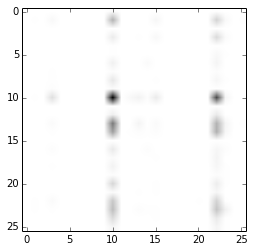

In [201]:
conf = confusion_matrix(dev_test_labels,actual_predictions)
plt.imshow(conf, cmap='binary')

In [202]:
pd.crosstab(dev_test_labels, actual_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,ASSAULT,BURGLARY,LARCENY/THEFT,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,RECOVERED VEHICLE,SUSPICIOUS OCC,VANDALISM,VEHICLE THEFT,WEAPON LAWS,All
True,,,,,,,,,,,,
ARSON,0,0,3,0,0,0,0,0,1,0,0,4
ASSAULT,1,4,41,0,0,0,5,0,23,4,1,79
BRIBERY,0,0,0,0,0,0,0,0,1,0,0,1
BURGLARY,0,0,11,0,1,0,4,0,20,3,0,39
DISORDERLY CONDUCT,0,0,1,0,0,0,0,0,1,0,0,2
DRIVING UNDER THE INFLUENCE,0,0,1,0,0,0,0,0,4,1,0,6
DRUG/NARCOTIC,0,0,8,0,0,3,0,0,6,0,0,17
DRUNKENNESS,0,1,2,0,0,0,0,0,2,0,0,5
FRAUD,0,1,13,0,0,0,1,0,5,1,0,21


Since samples are not weighted well in terms of categories, the model seems to be having difficulties with categories that have a larger amount of observations - likely because all of the conditions used to predict crimes are seen more frequently for the samples with more observations. To make the model generalize better, it will be necessary to resample the dataset so that possible outcomes are represented more evenly. 

#### Resample training data

In [203]:
g = train_raw.groupby('Category')
class_weights = np.ln(np.mean(g['Category'].agg(len))/g['Category'].agg(len))
class_weights_df = pd.DataFrame({'Category':class_weights.index.values,'Weight':class_weights.values})
train_raw['sample_weight'] = pd.merge(train_raw,class_weights_df,on=['Category'])['Weight']
print class_weights

Category
ARSON                            14.880421
ASSAULT                           0.292862
BAD CHECKS                       55.453391
BRIBERY                          77.903380
BURGLARY                          0.612545
DISORDERLY CONDUCT                5.211592
DRIVING UNDER THE INFLUENCE       9.926842
DRUG/NARCOTIC                     0.417151
DRUNKENNESS                       5.260298
EMBEZZLEMENT                     19.308814
EXTORTION                        87.945613
FAMILY OFFENSES                  45.853517
FORGERY/COUNTERFEITING            2.122168
FRAUD                             1.349846
GAMBLING                        154.206006
KIDNAPPING                        9.617290
LARCENY/THEFT                     0.128725
LIQUOR LAWS                      11.830834
LOITERING                        18.378838
MISSING PERSON                    0.866293
NON-CRIMINAL                      0.243912
OTHER OFFENSES                    0.178425
PORNOGRAPHY/OBSCENE MAT        1023.367133
PR

##### Add time of day 

In [204]:
def segment_time1(ts):
    ''' Segment time of day '''
    if ts.hour<=4: return 1
    elif ts.hour<=8: return 2
    elif ts.hour<=12: return 3
    elif ts.hour<=16: return 4
    elif ts.hour<=20: return 5
    elif ts.hour<=24: return 6
def segment_time2(ts):
    ''' Return only hour '''
    return ts.hour
def dayofmonth(ts):
    ''' Return day of month '''
    return ts.day
def yearofcrime(ts):
    ''' Return the year '''
    return ts.year

segment_time1 = np.vectorize(segment_time1,otypes=[np.int64])
segment_time2 = np.vectorize(segment_time2,otypes=[np.int64])
dayofmonth = np.vectorize(dayofmonth,otypes=[np.int64])
yearofcrime = np.vectorize(yearofcrime,otypes=[np.int64])

train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])

train_raw['DaySegment'] = train_raw['Dates'].apply(segment_time1)
test_raw['DaySegment'] = test_raw['Dates'].apply(segment_time1)

train_raw['TimeOfDay'] = train_raw['Dates'].apply(segment_time2)
test_raw['TimeOfDay'] = test_raw['Dates'].apply(segment_time2)

train_raw['DayOfMonth'] = train_raw['Dates'].apply(dayofmonth)
test_raw['DayOfMonth'] = test_raw['Dates'].apply(dayofmonth)

train_raw['Year'] = train_raw['Dates'].apply(yearofcrime)
test_raw['Year'] = test_raw['Dates'].apply(yearofcrime)

##### Add area of crime in place of lat/lon

Looking to test out a couple options for this feature. Currently, by using the exact location of the crime, the model does not generalize very well. A couple options are available: 1) utilize publicly available datasets on city neighborhoods to classify each event into a more generalized city segment, perhaps based on income levels, 2) use a clustering algorithm like K-means to segment the training data into clusters where there are crime "hotspots" and add one of these as a feature (replacing lat/lon and potentially address - will test the removal of features separately). 

I will first attempt #2 while looking for a good option for #1.

##### Get data from other sources

SF OpenData has a ton of supplemental data sources that will be great to try out for this effort.  

In [206]:
# http://spatialreference.org/ref/epsg/2227/
p = Proj('+proj=lcc +init=EPSG:2227 +datum=NAD83 +units=us-ft +no_defs',preserve_units=True)
convert_vals = np.vectorize(lambda x,y: p(x,y))
convert_vals_inv = np.vectorize(lambda x,y: p(x,y,inverse=True))

In [207]:
shpfilename_elect = 'Data/SanFranciscoElectricityUse/SanFranciscoElectricityUse.shp'
shpfilename_school = 'Data/schools_public_pt/schools_public_pt.shp'
shpfilename_zoning = 'Data/Zoning/Zoning_Districts.shp'

##### Process shapefiles

In [208]:
# Convert lat/lon to coordinates that match shp
train_raw['New_X'], train_raw['New_Y'] = \
    convert_vals(train_raw['X'],train_raw['Y'])

In [209]:
def make_points(x):
    ''' Create list of Points objects
    '''
    out = []
    n = x.shape[0]
    for i in range(n):
        out.append(Point((x['New_X'][i],x['New_Y'][i])))
    return out
points = make_points(train_raw[['New_X','New_Y']])

In [210]:
shp = fiona.open(shpfilename_school)
n = len(shp)
SCHOOL_TYP,\
DEPT,\
FACILITY_N,\
DEPTNAME,\
FACILITY_I = \
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25')
for i,s in enumerate(shp):
    SCHOOL_TYP[i] = s['properties']['SCHOOL_TYP']
    DEPT [i] = s['properties']['DEPT']
    FACILITY_N [i] = s['properties']['FACILITY_N']
    DEPTNAME [i] = s['properties']['DEPTNAME']
    FACILITY_I [i] = s['properties']['FACILITY_I']
shp.close()

props_df = pd.DataFrame({
        'Id':[i+1 for i in range(n)],
        'SCHOOL_TYP':SCHOOL_TYP
    })

In [211]:
set(props_df['SCHOOL_TYP'])

{'Charter School',
 'County School',
 'Early Education',
 'Elementary',
 'High School',
 'Middle School'}

In [212]:
hs = props_df[props_df['SCHOOL_TYP']=='High School']['Id']
cs = props_df[props_df['SCHOOL_TYP']=='County School']['Id']
chs = props_df[props_df['SCHOOL_TYP']=='Charter School']['Id']
ms = props_df[props_df['SCHOOL_TYP']=='Middle School']['Id']

In [213]:
def coord_search_schools():
    ''' Find nearest point and measure distance
        for every datapoint 
    '''
    shp = pysal.open(shpfilename_school,'r')
    pl_hs = BruteForcePointLocator([p for p in shp if p.id in hs])
    pl_cs = BruteForcePointLocator([p for p in shp if p.id in cs])
    pl_chs = BruteForcePointLocator([p for p in shp if p.id in chs])
    pl_ms = BruteForcePointLocator([p for p in shp if p.id in ms])
    shp.close()

    return_point_hs = lambda x: pl_hs.nearest(x)
    return_point_cs = lambda x: pl_cs.nearest(x)
    return_point_chs = lambda x: pl_chs.nearest(x)
    return_point_ms = lambda x: pl_ms.nearest(x)
    
    # point_ids = np.zeros(len(points),dtype=np.int8)
    point_distances_hs = np.zeros(len(points),dtype=np.float64)
    point_distances_cs = np.zeros(len(points),dtype=np.float64)
    point_distances_chs = np.zeros(len(points),dtype=np.float64)
    point_distances_ms = np.zeros(len(points),dtype=np.float64)
    
    def run_iters():
        for i,p in enumerate(points):
            if i%100000==0: print 'running {0} row'.format(i)
            pt_hs = return_point_hs(p)
            pt_cs = return_point_cs(p)
            pt_chs = return_point_chs(p)
            pt_ms = return_point_ms(p)
            
            point_distances_hs[i] = arcdist(p,pt_hs)
            point_distances_cs[i] = arcdist(p,pt_cs)
            point_distances_chs[i] = arcdist(p,pt_chs)
            point_distances_ms[i] = arcdist(p,pt_ms)

    run_iters()
    
    return point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms

In [214]:
# This runs relatively quickly 
point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms = coord_search_schools()

running 0 row
running 100000 row
running 200000 row
running 300000 row
running 400000 row
running 500000 row
running 600000 row
running 700000 row
running 800000 row


In [215]:
def run_iters_elect(plocator,return_poly_id):
    poly_ids = np.zeros(len(points),dtype=np.int8)
    for i,p in enumerate(points):
        if i%100000==0: print 'running {0} row'.format(i)
        poly_ids[i] = return_poly_id(plocator,p)
    # Save data because this step takes >5hrs to finish
    poly_ids_df = pd.DataFrame({'elect_poly_id':poly_ids})
    poly_ids_df.to_csv('Data/poly_ids.csv',index=False)

def run_iters_zoning(plocator,return_poly_id):
    poly_ids = np.zeros(len(points),dtype=np.int8)
    for i,p in enumerate(points):
        if i%1==100000: print 'running {0} row'.format(i)
        poly_ids[i] = return_poly_id(plocator,p)
    # Save data because this step takes >5hrs to finish
    poly_ids_df = pd.DataFrame({'zoning_id':poly_ids})
    poly_ids_df.to_csv('Data/zoning_ids.csv',index=False)

def return_poly_id(pl,x):
        ''' Find the polygon that 
            contains each point
        '''
        try:
            return pl.contains_point(x)[0].id
        except IndexError:
            return -1

def polygon_search(shpfilename,run_iters,\
                   return_poly_id=return_poly_id):
    ''' Iterate through shapefile polygons
        and find id of polgy for each datapoint
    '''
    shp = pysal.open(shpfilename,'r')
    pl = PolygonLocator([p for p in shp])
    shp.close()
    run_iters(pl,return_poly_id)

# polygon_search(shpfilename_elect,run_iters_elect)
# polygon_search(shpfilename_zoning,run_iters_zoning)

In [216]:
# only run this after ids are compiled
poly_ids_df_elect = pd.read_csv('Data/poly_ids.csv')

In [217]:
def run_iters(points, point_locator, centroids, \
              log_at=100000):
    ''' Iterate through points to find 
        the nearest centroid from shapefile
    '''
    point_fun = lambda x,pl: pl.nearest(x)
    id_fun = lambda p, centroids: [i for i,c in enumerate(centroids)\
                                  if c==p][0]
    nearest_ids = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: print 'running {0} row'.format(i)
        pt = point_fun(p,point_locator)
        pt_id = id_fun(pt, centroids)
        nearest_ids[i] = pt_id
    return nearest_ids

def save_file(array_to_save, colname, filename):
    ''' Write column to CSV '''
    array_to_save_df = pd.DataFrame({colname:array_to_save})
    array_to_save_df.to_csv(filename,index=False)

def coord_search(shpfile, points, \
                 run_iters_fun, \
                 locator_fun=BruteForcePointLocator):
    ''' Since polygon search is not efficient
        do a comparison to each centroid instead
    '''
    gather_centroids = lambda shp: [p.centroid for p in shp]

    # Read file
    shp = pysal.open(shpfile,'r')
    centroids = gather_centroids(shp)
    pl = locator_fun(centroids)
    shp.close()
    
    # Return the nearest points
    nearest_ids = run_iters_fun(points,pl,centroids)
    
    return nearest_ids

# zone_ids = coord_search(shpfilename_zoning,points,\
#                        run_iters)
# save_file(zone_ids, 'zoning_id', 'Data/zoning_ids.csv')

In [218]:
# only run this after zone ids are compiled
zone_ids = pd.read_csv('Data/zoning_ids.csv')

In [219]:
shp = fiona.open(shpfilename_zoning)
n = len(shp)
ZONING_SIM,\
DISTRICTNA = \
    np.empty(n,dtype='|S25'),\
    np.empty(n,dtype='|S25')
for i,s in enumerate(shp):
    ZONING_SIM[i] = s['properties']['ZONING_SIM']
    DISTRICTNA[i] = s['properties']['DISTRICTNA']
shp.close()

props_df_zoning = pd.DataFrame({
        'Id':[i+1 for i in range(n)],
        'ZONING_SIM':ZONING_SIM,
        'DISTRICTNA':DISTRICTNA
    })
all_zones = pd.merge(zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])

In [220]:
shp = fiona.open(shpfilename_elect)
n = len(shp)
kWh_pC,\
kWh,\
Zip,\
Pop2010_zc = \
    np.empty(n,dtype=np.float64),\
    np.empty(n,dtype=np.float64),\
    np.empty(n,dtype='|S10'),\
    np.empty(n,dtype=np.int64)
for i,s in enumerate(shp):
    kWh_pC[i] = s['properties']['kWh_pC']
    kWh [i] = s['properties']['kWh']
    Zip [i] = s['properties']['Zip']
    Pop2010_zc [i] = s['properties']['Pop2010_zc']
shp.close()

props_df_elect = pd.DataFrame({
        'Id':[i+1 for i in range(n)],\
        'kWh_pC':kWh_pC,\
        'kWh':kWh,\
        'Zip':Zip,\
        'Pop2010_zc':Pop2010_zc\
    })
all_elects = pd.merge(poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])

##### Add new columns

In [221]:
elect_cols = ['kWh_pC','kWh','Zip','Pop2010_zc']
train_raw[elect_cols] = all_elects[elect_cols] 

In [222]:
school_nearby = np.vectorize(lambda x: True if x<=1000 else False)
train_raw['HS_DISTANCE'] = point_distances_hs.astype(np.float64)
train_raw['CS_DISTANCE'] = point_distances_cs.astype(np.float64)
train_raw['CHS_DISTANCE'] = point_distances_chs.astype(np.float64)
train_raw['MS_DISTANCE'] = point_distances_ms.astype(np.float64)
train_raw['HS_NEARBY'] = school_nearby(train_raw['HS_DISTANCE'])
train_raw['CS_NEARBY'] = school_nearby(train_raw['CS_DISTANCE'])
train_raw['CHS_NEARBY'] = school_nearby(train_raw['CHS_DISTANCE'])
train_raw['MS_NEARBY'] = school_nearby(train_raw['MS_DISTANCE'])

In [223]:
train_raw['ZONING_SIM'] = all_zones['ZONING_SIM']
train_raw['DISTRICT_NAME'] = all_zones['DISTRICTNA']
train_raw['ZONE_ID'] = all_zones['Id']

##### Test performance

In [ ]:
s = 10000 
old_fields = ['PdDistrict'\
              ]
new_fields = ['PdDistrict'\
              ,'Year'\
             ]
cat_fields = [
    'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
    'Zip',\
    'HS_NEARBY','CS_NEARBY','CHS_NEARBY','MS_NEARBY',\
    'ZONING_SIM','DISTRICT_NAME','ZONE_ID'
]

nt = train_raw.copy().iloc[\
                        np.random.permutation(len(train_raw))]

for f in (old_fields,new_fields):
    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(f) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=False)
    rf = RandomForestClassifier(n_jobs=2, n_estimators=20,\
                               random_state=10) 

    dev_train, dev_train_labels = nt[f][s+1:],\
                            nt['Category'][s+1:]
    dev_train_weights = np.array(nt['sample_weight'][s+1:])
    dev_test, dev_test_labels = nt[f][:s],\
                            nt['Category'][:s]
    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('rf', rf)])
    pl.fit(dev_train, dev_train_labels, rf__sample_weight=dev_train_weights)
    print 'Accuracy {0}: {1}%'.format(
        f
        ,round(pl.score(dev_test, dev_test_labels),4)*100
    )

Test Notes:
* Adding time of day increased accuracy by ~2 percentage points, until I implemented random shuffling prior to testing - then the impact of adding time of day was negligable or negative in most trials. 
* Time of Day as an hour originally performed better than 4-hour blocks; however, after implementing random shuffling the day segment field performed better across multiple tries.
* Adding day of month reduced model performance due to overfitting. 
* Adding year reduced model performance due to overfitting. 
* Adding Address significantly reduces model accuracy due to overfitting
* Day of week significantly reduces model accuracy due to overfitting
* Lat/Lon significantly reduces model accuracy due to overfitting
* The actual expected accuracy is still very bad (<30%)

In [ ]:
new_fields = [
    'PdDistrict','DaySegment',\
    'kWh','Zip','Pop2010_zc','Year'
]
cat_fields = [
    'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
    'Zip',\
    'HS_NEARBY','CS_NEARBY','CHS_NEARBY','MS_NEARBY',\
    'ZONING_SIM','DISTRICT_NAME','ZONE_ID'
]

le = MultiColumnLabelEncoder()
imp = Imputer(strategy='most_frequent')
cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
ohe = OneHotEncoder(categorical_features=cf,sparse=False)
rf = RandomForestClassifier(n_jobs=2, n_estimators=500) 
pca = PCA(n_components = 6)

train_raw = train_raw.iloc[\
                    np.random.permutation(len(train_raw))]
dev_train, dev_train_labels = train_raw[new_fields][10001:],\
                        train_raw['Category'][10001:]
dev_train_weights = np.array(train_raw['sample_weight'][10001:])
dev_test, dev_test_labels = train_raw[new_fields][:10000],\
                        train_raw['Category'][:10000]


pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('rf', rf)])
pl.fit(dev_train, dev_train_labels, rf__sample_weight=dev_train_weights)
print 'Accuracy: {0}%'.format(round(pl.score(dev_test, dev_test_labels),4)*100)
print pl.named_steps['rf'].feature_importances_ 
print np.cumsum(pl.named_steps['pca'].explained_variance_ratio_)

#### Part 3 - Error Diagnosis

In [232]:
predictions = pl.predict(dev_test)
labels = pl.transform(dev_test_labels)
conf = confusion_matrix(labels,predictions)
plt.imshow(conf, cmap='binary')
pd.crosstab(labels, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

NotFittedError: This Imputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.